In [1]:
%%time

import time 
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import torch
import re

from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:70% !important; }</style>"))

pylab.rcParams.update(
    {
        "legend.fontsize": "small",
        "font.size": 12,
        "figure.figsize": (6*3, 2.2*3),
        "axes.labelsize": "small",
        "axes.titlesize": "medium",
        "axes.grid": "on",
        "xtick.labelsize": "small",
        "ytick.labelsize": "small",
    }
)

def timeit(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        delta = end - start
        print(f"{func.__name__} runtime: {delta:.2f} sec")
    
        return result
    return wrapper

<timed exec>:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


CPU times: user 1.5 s, sys: 1.81 s, total: 3.31 s
Wall time: 574 ms


---
## Fraktur Translator

In [2]:
import base64
import requests
import openai
import glob
import json 
from pdf2image import convert_from_path
import re
from io import BytesIO
from docx import Document
from PIL import Image

def create_docx(english_texts, folder_name='',English='English'):
    document = Document()
    for page in sorted(english_texts.keys()):
        text = english_texts[page]

        # Replace multiple '\n' characters with a single '\n'
        text = re.sub(r'\n+', '\n', text)

        document.add_heading(f"Page {page}", level=1)
        document.add_paragraph(text)

    document.save(f'output/{folder_name}/{English}.docx')


def encode_image(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")  # Save the image to the BytesIO object in memory
    return base64.b64encode(buffered.getvalue()).decode('utf-8')


def construct_payload(base64_image, model_name="gpt-4o-mini-2024-07-18"):
    payload = {
        "model": model_name,
        "messages": [
          {"role": "system", "content": "You are a professional OCR assistant."+\
           "You read German text written in Fraktur typeface. When you are given a page, "+\
           "you can carefully separate the header from the body of the page on the page layout"},
          {
            "role": "user",
            "content": [
              {
                "type": "text",
                "text": "First, transcribe this whole page into German and wrap the translation inside the "+\
                  "following tags: <german></german>. "+\
                  "If there's a header or a Chapter Heading at the top of the page, "+\
                  "wrap it between <header></header> tags. "+\
                  "After the German transcription is finished, translate it into English "+\
                  "and wrap the English translation between <english></english> tags."
              },
              {
                "type": "image_url",
                "image_url": {
                  "url": f"data:image/jpeg;base64,{base64_image}"
                }
              }
            ]
          }
        ],
        "max_tokens": 10000
    }
    return payload


def save_images(y_lo, y_hi, x_lo, x_hi, arr, pageno):
    # Save original and cropped image
    fig = plt.figure(figsize=(15,15))
    image = Image.fromarray(arr[y_lo:y_hi, x_lo:x_hi])
    plt.imshow(image); 
    plt.gca().axis('off')
    plt.savefig(f'figures/{pageno}_cropped.png', bbox_inches='tight')

    plt.imshow(image); plt.gca().axis('off')
    image = Image.fromarray(arr)
    plt.imshow(image); 
    plt.gca().axis('off')
    plt.savefig(f'figures/{pageno}.png', bbox_inches='tight')
    plt.close(fig)


def compute_log_spectrum(arr, plotter=False):
    two_dim_img = np.mean(arr, axis=2)
    meany = np.mean(two_dim_img, axis=0)
    two_dim_img -= meany

    ffty = np.array([np.fft.fft(two_dim_img[:,i]) for i in range(two_dim_img.shape[1])]).T
    log_spectrumy = np.log(np.abs(ffty) ** 2 + 1)

    if plotter:
        # Plot the energy spectrum as a function of x
        plt.imshow(log_spectrumy, aspect='equal', cmap='hot')
        plt.colorbar(label='Log Energy Spectrum')
        plt.title('Energy Spectrum Along Y-axis (As a Function of X)')
        plt.xlabel('X-axis')
        plt.ylabel('Frequency (Y-axis)')
        plt.show()

    # ----------------------------------------------
    two_dim_img = np.mean(arr, axis=2)
    meanx = np.mean(two_dim_img, axis=1)
    two_dim_img -= meanx[:,np.newaxis]

    fftx = np.array([np.fft.fft(two_dim_img[i]) for i in range(two_dim_img.shape[0])])
    log_spectrumx = np.log(np.abs(fftx) ** 2 + 1)

    if plotter:
        # Plot the energy spectrum as a function of x
        plt.figure()
        plt.imshow(log_spectrumx, aspect='equal', cmap='hot')
        plt.colorbar(label='Log Energy Spectrum')
        plt.title('Energy Spectrum Along Y-axis (As a Function of X)')
        plt.xlabel('X-axis')
        plt.ylabel('Frequency (Y-axis)')
        plt.show()

    return log_spectrumx, log_spectrumy


def extract_image_bbox(log_spectrum, axis='y', plotter=False):
    axis = 0 if axis == 'y' else 1
    form = np.mean(log_spectrum, axis=axis) - np.mean(log_spectrum)
    n = len(form)

    lo = None
    for i in range(len(form)):
        if lo is None and form[i] > 0 and all(form[i:i+5] > 0):
            lo = max(0, i-5)
            if plotter: 
                print('lo', lo)
            break

    hi = None
    for i in range(len(form)-1, -1, -1):
        if hi is None and form[i] > 0 and all(form[i-4:i+1] > 0):
            hi = min(i+5, len(form)-1)
            if plotter: 
                print('hi', hi)
            break

    if plotter:
        plt.plot(form, 'k', alpha=.6)
        plt.plot(range(lo,hi+1), form[lo:hi+1], 'rd', alpha=.6)

    return lo, hi+1


In [3]:
# OpenAI API Key
openai.api_key = os.getenv("OPENAI_API_KEY")

models = {"gpt-4o-2024-08-06" : {"price_txt":"$2.50 / 1M input tokens", 
           "price_img":"$0.001913 / 1500px^2"},
          "gpt-4o-mini-2024-07-18" : {"price_txt":"$0.150 / 1M input tokens, $0.600 / 1M output tokens", 
           "price_img":"$0.003825 / 1500px^2"},
         }

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {openai.api_key}"
}

# folder where the Fraktur PDFs are
image_path = "Der Weltkrieg v8 Chap 4F (in Fraktur)/*pdf"
pdf_files = sorted(glob.glob(image_path))
german_texts = {}
english_texts = {}
total = 0


In [4]:
model_name = "gpt-4o-mini-2024-07-18" # "gpt-4o-2024-08-06", "gpt-4o-mini-2024-07-18"]
for i, pdf_file in enumerate(pdf_files):
    start = time.time()
    pageno = re.search(r'page_(.*?)\.pdf', pdf_file, re.DOTALL).group(1)
    print(f"{'-'*50}\npage:{pageno} ({i}/{len(pdf_files)-1}) ",end="")
    
    image = convert_from_path(pdf_file)[0]
    
    # crop image accourding to its fourier frequency spectrum.
    arr = np.array(image)
    log_spectrumx, log_spectrumy = compute_log_spectrum(arr)
    x_lo, x_hi = extract_image_bbox(log_spectrumy, 'y')
    y_lo, y_hi = extract_image_bbox(log_spectrumx, 'x')
    save_images(y_lo, y_hi, x_lo, x_hi, arr, pageno)
    
    
    base64_image = encode_image(image)
    
    response = requests.post("https://api.openai.com/v1/chat/completions", 
                             headers=headers, 
                             json=construct_payload(base64_image, model_name))
    content = response.json()['choices'][0]['message']['content']
    
    german_text = re.search(r'<german>(.*?)</german>', content, re.DOTALL).group(1)
    english_text = re.search(r'<english>(.*?)</english>', content, re.DOTALL).group(1)
    german_texts[pageno] = german_text
    english_texts[pageno] = english_text
    
    lines = f"page:{pageno} ({i+1}/{len(pdf_files)})"
    delta = time.time() - start
    total += delta
    print(f"time:{delta:.2f} sec\n{'-'*50}\n\n{german_text}")

print(f"\n[Runtime {int(total//60)} mins {(total - int(total//60)*60):.2f} sec]") 

--------------------------------------------------
page:456 (0/83) time:18.96 sec
--------------------------------------------------


F. Die Operation des Oberbefehlshabers Ost gegen Wilna.

1. Die Kämpfe in Litauen und dem Ruland bis Ende August*).
a) Die Kämpfe der Niemen-Armee.
(Karten 6 und 7, These 26.)

Der Juli-Feldzug gegen Mitau und Schaulen. 
Vom Monat Juli ab sind die Kämpfe der Niemen-Armee nicht mehr als selbständige Einzelhandlung, sondern als Vorbereitung einer künftigen Offensive auf Wilna zu werten, die der Oberbefehlshaber Ost als wirkungsvolle Unterstützung der Offensive in Südböhmen am 2. Juli in Posen vorgeschlagen hatte, und die für einen späteren Zeitpunkt auch die Billigung des Generals von Talleyrand gefunden hatte*). Der Oberbefehlshaber Ost behielt sie unentwegt im Auge. Sollte diese Durchbruchsoffensive so tief in die feindliche Aufstellung eindringen, dass sie volle Wirkung hatte, dann musste eine große Gefährdung von oben erfolgen werden, die den Nordflüg

page:460 (4/83) time:23.04 sec
--------------------------------------------------


460 Die Operation des Oberbefehlshabers Aft gegen Wilna. 

Korps Morgen zu weiterem Angriff bereitstehen, während südlich vom Raftion-Ober die Südgruppe auf ziemlich 40 Kilometer breiter Front mit dem rechten Flügel auf Guzdani zum Angriff vorzubereiten hatte. Vom Nordkorps lösten als Umschließungsflügel die 78. Reserve-Division Shagori, das Kavalleriekorps Schmetton Groß Wilzen direkt. Die 41. Infanterie-Division und die bisher dem Generalleutnant von Pappritz unterstehenden Truppen hatten nicht auszuarbeiten und, nehmend, im Standstreit zu nehmen; die Führung erhielt der Kommandeur der 8. Kavallerie-Division, Generalmajor Eberhard Graf von Schmetton.

Insbesondere waren die h i n t e r f r i s t, nach dem Geschehe bei Defstergam am 2. Juli, durch das IV. Geschwader (fießen ältere Linien schöpfe) und leichte Streifkräfte aus der Nordseite vorzubehend bedeutend verstärkt worden. Der Oberbefehlshaber Aft

page:463 (7/83) time:22.39 sec
--------------------------------------------------

Neue Aufträge für 10. und Njemen-Armee.  
gestellten Kämpfen und Märschen haben die Truppen Auszeichnungen gezeichnet. „Demnächst“, meldete der Oberbefehlshaber Olf an diesem Tage an den Obersten Kriegsheer.„ Er selbst beurteilte die Lage nunmehr wie folgt“: Für die weitere Durchführung der Operation in Richtung Wilna, die diesseitigen Kräften allein aufgetragen ist, ist die Njemen-Armee „zu schwer; eine Aufbringung von Kräften ist zur Zeit nicht möglich“. Wodurch aber kann diese Operation, auf der es nach diesseitiger Ansicht nach Abschluss der Varlen-Operation kommen muss, vorbereitet werden. Hierzu gehören: die Einnahme von Mitau, weil der Aufruf über Riga Kräfte hinführen und die Bewegungen in der Flanke bedrohen kann, und Vorbereitungen für die Einnahme von Rovno. Der Zeit dieser Festung ist notwendig sowohl für die Offensive in Richtung Wilna über öffentliches aufgrund der Hauptstraße von Zichernün

page:467 (11/83) time:26.08 sec
--------------------------------------------------


Abwehraufgabe für die Njemen-Armee. 

„Äußerlich hat der Njemen das Rußland natürlich die Gefahr längst erkannt, und es fährt, was er kann, nach Wilna, Dünaburg und Riga. Hoffentlich gelingt es ums bald, wenn Gallwitz gut vorwärts kommt, von dort Kräfte herauszuziehen.“ Angesichts dieser Verhältnisse entschloss sich der Oberbefehlshaber, die Aufgaben der 10. und Njemen-Armee neu zu regeln. Die Einschließung von Rovno sollte für die 10. Armee allein zunehmen. Statt der Division Benndamm trat aber von der Njemen-Armee nur die Abteilung Eberhardt über, die vor Rovno den Abschluß der 4. Kavallerie-Division mitübernehmen hatte, so dass diese nur für die Njemen-Armee an anderer Verwendung frei wurde. Diese, so hieß es in dem Befehl, „nötig die linke Flanke des Feindes gegen einen entscheidend feindlichen Vorstoß von der unteren Dünab. Die Behauptung Mittaus und des genommenen feindlichen Gebietes ist dabei v

page:471 (15/83) time:30.42 sec
--------------------------------------------------


ben an den Sieg noch aufsehen wollte. Gerade dadurch aber hat das überlegene operative Können und die höhere Kampfskraft der Deutschen in diesen Kämpfen verhältnismäßig größere Erfolge erzielen können, als überall da, wo der Feind mit mehr Vorsicht verfuhr und drobenden Gefahr aber schließlich aussichtslos. Die deutsche Seite der stattfindenden Kämpfe bis zum 24. Juli beträgt allein 27 000 Gefangene, 40 Maschinengewehre und 25 Geschütze. Dem standen rund 5000 Mann eigene Verluste gegenüber.

Nach russischem Urteil wurde die Fortsetzung des deutschen Angriffs in den Lagen vom dem 25. Juli auf Grundlage der noch verbliebenen russischen Kräfte geführt haben; seine Einstellung gestaltete die Russen, die nach ihrer geschätzten Zeit dem 14. Juli mindestens 30 000 Mann verloren hatten, nicht durch Aufklärung und Crise bald wieder zu erholen und sich darüber hinaus idealerweise angreifen, wobei für bis zum 20.

page:475 (19/83) time:22.83 sec
--------------------------------------------------

10. Armee. Vorbereitung des Angriffs gegen Rowno. 475
umgebaut und verstärkt worden waren. Ein weiterer vier bis fünf Kilometer vorgeschobener düsterer Fortsgürtel war damals im Entstehen gewesen. In Anlehnung an diese ausgedehnten ständigen Werke zur Verteidigung in nahezu zwölf Kriegsmonaten weiter ausgebaut und durch vorgeschobene Stellungen verstärkt worden, so dass sie als besonders widerstandsfähig anzusehen waren. Der beim Großen Generalstab im Frieden ausgearbeitete Angriffsplan empfiehlt, die Südfront anzugreifen, die von der entschiedenen Fejta in zwei Hälften geteilt wird. Für Artillerieaufmärsche und Munitionsversorgung stand nur die Königsberger Bahn zur Verfügung. An Kräften waren allein schon gegen den nördlichen engen Umring des Platzes etwa zwei Korps, rund 400 Geschütze, davon gegen 250 schwerere unter ihnen zwei schwere Batterien) als erforderlich angesehen worden. Was die 10. Armee e

page:479 (23/83) time:22.13 sec
--------------------------------------------------


10. Armee. Der Angriff auf Kowno.  
Oberkommando und dem Generalkommando Lignman festgelegt, hat gegen die Forts III und II ein zeitweiliges Wirkungsziel durchführt werden sollen, seihen Leitung dem inzwischen bei der Armee eingeführten General der Fußartillerie, Generalkommando Schabel, übertragen war. General Lignman wollte am zwischen 11° und 12° mittags den Sturmangriff beginnen, falls die Divisionen sich nicht inzwischen schon von selbst begonnen hätten. Überhaltendes Feuer der mittlerweile auf 208 geschossenen und 10 schwerstes Geschütze, angeführten Artillerie, durch Flieger- und Wallondbeobachtung gut geleitet, erschütterte die Bejagung der russischen Werte und Stellungen völlig. General Lignmann befahl den Sturm. Am 2 nachmittags durchbrachen Truppen der 79. Reserve- und 115. Infanterie-Division die russischen Stellungen zwischen Fort III und II und nahmen in Einschluss daran beide Forts, währ

page:483 (27/83) time:19.06 sec
--------------------------------------------------

Als dann am 18. August konowo genommen war und Nowogrodek unmittelbar vor dem Fall stand), wurde die Frage des weiteren Angriffs der 10. Armee besprochen. Der Oberbefehlshaber Ost meldete an diesem Tage an die Oberste Heeresleitung, er beabsichtige, die Einsatztruppen von Nowogrodek auszuführen, um sich die Offensive über den Niemen abwärts von Grodno zu ermöglichen. Die halbe 83. Landwehr-Division würde der 12. Armee zugeteilt werden. Sollte die Oberste Heeresleitung in der Lage sein, außerdem noch weitere Kräfte zu einer Offensive von Nowon in Richtung auf Wilna zu überweisen, so würde er sich, sofern einem weitgehenden Erfolg versprechen. Die noch am gleichen Tage eingehende Antwort des Generals von Tallenhayn lautete: „Gegen Heranziehung der Einsatztruppen von Nowogrodek nach Fall der Festung zur 10. Armee bestehen keinerlei Bedenken. Ebenso entspricht geplante Offensive über Niemen unterhalb Grodno

page:487 (31/83) time:20.17 sec
--------------------------------------------------


Vormarscht der 10. Armee auf Wiłna. 487

jetzt bereits auf dem südlichen Niemen-Ufer, die Gegend nördlich von D i t a erreicht, heißen westlich des Stromes gelegene Wälder, vier ältere Forts, von den Russen verlassen und schon in deutscher Hand waren. Von diesen Hauptkräften der Armee wurde 25 Kilometer Zwischenraum getrennt, hatte der auf den Divisionen verstaute Süßflügel in der Richtung auf den Flussbogen von Merecz, um den Augustowski Wald mehr Raum gewinnen können. Alles in allem vollzog sich dieses Vorgehen auf der ganzen Armee mit fortdauernden Kämpfen, wobei der Gegner verhältnismäßig viel Artillerie zeigte, darunter auch schwere.

Der Oberbefehlshaber D f hatte bereits damit gerechnet, dass die Russen weiter langsam hinter den Niemen ausweichen und möglicherweise abweichende Kräfte nach Nordenverschieben würden. Um mehr zu bewirken, ergehe Wiłna nicht schon stärker zu sein; auf die bei Nowogro

page:491 (35/83) time:22.32 sec
--------------------------------------------------

Aus-einandersetzungen mit der Obersten Heeresleitung. 

schwere Artillerie, die im Auguststurm eintritt, wird ihr unterstellt. Anschluss nach rechts an 12. Armee; nach links behält sie sich bis an den Augustzwölf-Kanal nördlich Sopronhe aus. – 10. Armee greift weiter Richtung Dramy-Wilna an, Schwerpunkte möglich auf und nördlich Wilna. Niemen-Armee greift vor Friedrichstadt an und fährt weiterhin gegen die obere Wilna. Damit wird der 10. Armee der Angriff auf Grodno abgenommen, so dass sie die ganze Kraft gegen Wilna einsetzen konnte. Der Befehl wurde am 30. August dabei ergänzt, daß die 12. und 8. Armee das Generalkommando des 1. Armeekorps nebst 2., 58., 88. Infanterie-, 10. Landwehr- und 9. Kavallerie-Division an die 10. Armee abzutreten, also noch etwas mehr als am 26. August beachtet war, und zwar auf einem möglichst einheitlichen Vorgehen bezüglich der Bezirks- (bei Billetdöners). Umfassung des fe

page:495 (39/83) time:22.74 sec
--------------------------------------------------

12., 8. und 10. Armee.  
durchgeführt und die Verstärkungen heran waren, musste etwa eine Woche vergehen.  
Inzwischen führte der Gegner, der die drohende Gefahr immer mehr entfernen musste und durch den Rückzug aus Polen Kräfte frei bekommen hatte, unter Einsatz seines Gardekorps am 1. und 2. September heftige, aber für ihn selbst überaus verlustreiche Gefechtshandlungen im Raum von Trofimow und nördlich der Biala. Alle diese Versuche scheiterten an der Widerstandskraft der gebliebenen Luttmann und Garnier. Am 3. September flauten die russischen Angriffe ab.  
Im Norden wollte die Niemen-Armee ihren Drud, der bisher mit Erfolg gegen die untere Dünna, auf Friedichstadt, gerichtet gewesen war, allemählich mehr südwärts ausdehnen. Als äußerster rechter Flügel dieser Armee fiel die 3. Kavallerie-Division seit dem 3. September an der Schirwinta nordwestlich von Schirwint Führung mit dem Nordflügel der 10. A

page:499 (43/83) time:17.82 sec
--------------------------------------------------

Schlacht bei Wilna. Bereitstellung zur Umfassung.

Bei der 10. Armee war die Bereitstellung zum Umfassungsangriff im wesentlichen durchgeführt. Hinter der Front der Gruppen Ligtmann und Garnier standen acht Infanterie-Divisionen bereit, zwei Kavallerie-Divisionen bildend, die nördlich von Wilkomierz reichend, den äußeren linken Flügel. Für den 9. September befehl Generaloberst von Eichhorn unter Neuausstellung der Armee den Beginn des massiven Angriffs auf Wilna. Er ging dabei von der Annahme aus, dass der Gegner jetzt vor seiner Front mit etwa fünf Divisionen (nördlich und neun Divisionen südlich der Wilia) zur Abwehr bereitstehe. Den Nordflügel diese nun 20 feindlichen Divisionen nahm er bei Schriftlinie an der Schirwindt an, während nördlich bis zur Straße Wilkomierz-Dünaburg schoen aber zu Zeit nie Kavallerie zu stehen. Generaloberst von Eichhorn selbst trat vor den Angriff insgesamt über 17½ Infant

page:503 (47/83) time:24.23 sec
--------------------------------------------------


Schlacht bei Wiela. Fortsetzung der Umfassungsbewegung.   

Der Oberbefehlshaber Licht blieb auf seine eigenen Kräfte angewiesen; der Gegner aber schien inzwischen vor dem überaus schwachen Nordflügel der Niemen-Armee zurückzutreten (nordöstlich von Riga sollte ein neues Armee-Oberkommando eingezogen werden sein). Das durfte die einseitige Operation nicht stören. Wenn auch die Niemen-Armee mit ihrem rechten Flügel bisher im Angriff bleiben wollte, so fasste der Oberbefehlshaber Licht doch ins Auge, die bei der 12. Armee herausgezogene 3. Infanterie-Division nummber bei der Niemen-Armee statt bei der 10. Armee einzusetzen. Diese wurde angewiesen, entweder mit der starken Grundtruppe, nach rückwärts zu marschieren, um den Gegner festzuhalten und daran zu binden, Kräfte zur Umfassung entgegenzuwirken, oder aber Kräfte nach hinten zu verschieben, um den Druck der Umfassung nachhaltiger zu machen. 

Vor der

page:507 (51/83) time:20.40 sec
--------------------------------------------------

Derbhung von Osten her zur Zeit nicht vorliege. Ferner sei mit großer Wahrscheinlichkeit damit zu rechnen, daß die Bahnliniem Moldiceano-Polozf und Moldoceano-Biina am 15. September durch die in diesem Instand entstandene Kavallerie nachfolgend zerstört worden. Im übrigen gälte wie die starke Gewehrsalve in ben für abschriftsweise Auflagen an ridenden Kräfte günstigen Gelände weitgehende Sicherheit für die Armee pflanze. „Diese Gewemotstellungn“, heisst es in der Weiszeichnung weiter, wurden nicht ernsthaft, wurde Oberst sei eröffnet, habe das Oberbefehlshaber Ost Abdrücken der Divisionen zu konzentrierten Angriffe spätestens am 16. September verlangen, und hinzugefügt, daß der telefonische Befehle kaum alsdann erlassen werden würde.“

Dieser entscheidende B e s c h e l d des Oberbefehlshabers Ost lautete: „Ich erwarte, daß die Armee spätestens am 16. September auf ihrer ganzen Front angreift, da bei sp

page:511 (55/83) time:20.27 sec
--------------------------------------------------

Der Höhepunkt der Schlacht bei Wilna.

Berlin weiterfuhr, trug Generalfeldmarschall von Hindenburg dem Kaiser über die Lage vor und gab im Anschluss daran seinen Armeen bekannt, er bade dem Obersten Kriegsheer die Versicherung gegeben, dass sie „das Letzte gegeben werden, um den Russen zu schlagen. Ich weiß, dass ich mich auf meine Armeen verlassen kann“.

Am 17. September sollte der Angriff weiter gehen, aber schon vor der wurde erkannt, dass der Gegner vor der ganzen Front der Gruppe Lisztmann und dem rechten Flügel der Gruppe Jüter nahm, den Rü-c^g an zu genehmigte hatte, der sich schließlich auch nach Süden bis vor den linken Flügel der Gruppe Carlowits absetzte. Man erblickt darin mit Recht die Wirkung des nun schon eine Woche währenden deutschen Angriffs. Die Aussicht, den Gegner noch vernichtend zu treffen, hatte sich damit aber vermindert, insbesondere, da er weiter sichtbar noch standhaft. 

Hi

page:515 (59/83) time:23.76 sec
--------------------------------------------------

Schlacht bei Wilna. Weitere Kräfteverschiebung nach links. 

Korps¹) gegen Smorgon angreifen und andere von Minsk auf Molodeczno anwiesen. Allerdings standen westlich von Smorgon immer noch etwa acht russische Korps; ihr Radius musste sich in der Gegend westlich von Molodeczno ziehen, da die Gesamtgliederung des russischen Heeres nördlich der Narew-Schneise nach Nordosten wies. Aus diesen Verhältnissen, so wie der deutschen Führung, wurden für die Bewegungen des Gegners derartige Schwierigkeiten entstehen, dass Aussicht war, wesentliche Teile noch nachzuschieben, sofern es gelang, den eigenen linken Flügel rechtzeitig daran zu verstärken, dass er nach Süden entscheidende Fortschritte machte.

Der Oberbefehlshaber Ist wie auch das Oberkommando 10, das mit seinen Korps seit dauernd in Fernsprechverbindung stand, trat jedoch immer wieder mit allen Mitteln auf Schieben nach links zur Verlagerung und Verstär

page:519 (63/83) time:26.42 sec
--------------------------------------------------

Schlacht bei Wilna. Ausführlicher Gegennagrist.  

(1., 4. und 3. Division) einrichten, von dem große Teile zurückgenommen wurden. Außerordentliche Marschleitungen der herausnehmenden Divisionen waren dazu erforderlich gewesen. Die Bilanz der linken Flügel bildenden 115. Infanterie-Division hatte in den letzten fünf Tagen 180 Kilometer zurückgelegt; durch die Gewaltleistung und die vorübergegangenen Kämpfe waren die Geschäfte stark erniedrigt auf etwa 300 Gewirre gesunken. Weiter sichtlich waren die bayerische und 9. Kavallerie-Division von Krzywilce und Obolichow nach Gilden und Südwesten angesetzt gewesen, um im Slant zu rüden des anrührenden Gegners zu treffen. Statt dessen mussten sie feststellen, daß sich der russische Flügel mit Infanterie bis Flaic, mit Kavallerie noch weiter nach Osten ausdehnte, die Front der 10. Arme alos immer noch erheblich übertrage.  

Inzwischen war die besonders schwieri

page:523 (67/83) time:22.53 sec
--------------------------------------------------


Das Ende der Schlacht bei Wilna.  
Kanal von Teleszany ab—Überlauf der Wiera (Saczara—Serwetisch)—Mündung der Berezyna in den Niemen fort, in der sie ebenfalls losgelöst mit der Einrichtigung für die Dauer beginnt. — Heeresgruppe Hindenburg richtet während dem Raum zwischen der Berezyna-Mündung in den Niemen und der Küste. Außerdem den schon angeforderten Verbänden, zwei Generalkommandos und sechs Divisionen, werde diese Heeresgruppe später vermutlich noch ein Generalkommando und fünf Divisionen dazugeben haben. Zwei Divisionen wurden im November wohl so möglich zur Eisenbahn nach Markow zu senden, Beschleunigung für beide Lagen im Westen herbeizubringen.  
Das heißt es an diesem Tage im Kriegstagebuch des Oberbefehlshabers Ost: „Damit ist der erste Anstoß zum Einstellen der Operation gegeben. Erst das Zusammentreffen der beiden Momente: Behelf der Obersten Heeresleitung und ihr Anhalt der Heeresgruppe

page:527 (71/83) time:23.35 sec
--------------------------------------------------


Schlacht bei Wilna. Russische Maßnahmen. Betrachtungen.

weitere Armeen nicht genießen, die zunächst hinter dem Umfassungsflügel gefasst, mit Beginn des Angriffs nordwestlich von Wilna von Bormann über die Grenzen am Wilna antrat. Da sie fehlte, hatte es zwei Bedenten, beide Ziele zugleich zu verfolgen. Wollte man mit den nun einmal nur verfügbaren geringen Kräften operativ in die Tiefe der russischen Flanke vorstoßen, beim Gegner durch teilweise besonders Terraingewinn einzufügen und dann abzurutschen, so musste man auch das Vagins in Kauf nehmen, die Angriffsfront für den russisch feindlich von Wilna frühzeitig nicht mehr zu schwächen und den Stoß in die Tiefe mit einer Gruppe von mindestens sechs, möglichst aber noch mehr Infanterie-Divisionen durchzuführen. Ob jedoch der Gegner, der die kürzeren Wege und gute Straßenverbindungen hatte, dann nicht mit Truppen, die auch er aus der Front westlich von 

page:531 (75/83) time:25.19 sec
--------------------------------------------------

Schlacht bei Wilna. Betrachtungen. 531 ähnlichen Umfang annahmen wie bei der 8. und 12. Armee. Die Schwierigkeiten endeten ein Stück weit rund 150 Kilometer hinter der Front an den seitlichen Niemen-Brücken von Ditia und Grodno*. Außerdem hatte das dauernde Rinschieben dabei genügt, gefüllte Kolonnen der ursprünglichen Flügeldivisionen von weiter verlängernden zuzuweisen, so dass auf der Weite des Weges sich noch gewisse Reibungen stellten, die um so größer wurden, je mehr Divisionen der ganzen Front entglitten auf ein und demselben Umarbeitungsexe zu verfroren waren. So konnte es schließlich kommen, dass beispielsweise ein Regiment der Armee meldete, es sei wegen ganz besonderen Mangels an Verpflegung gescheitert. Ein Zusatzempenstoff verschärfte die Schwierigkeiten noch, indem er den Verkehr nach Wilna für einen Tag unterbrach. Bei Fortgang der Kämpfe in demselben Raume mussten die Verhältnisse in zun

page:535 (79/83) time:35.09 sec
--------------------------------------------------

Die Kämpfe der Niemen-Armee.  
so wirksam unter Feuer hielt, dass die Russen den Bergh über Pleßau umleiten mussten. Im übrigen hatte das elf tägige Unternehmen rund 5000 Gefangene, wobei fast die Hälfte am 2. und 3. September, und zwei Sichtfelder als Beute gebracht.  
Inzwischen hatte auf dem rechten Flügel der Armee die Gruppe Launstein schon gegen Ende August ihre Linien an verschiedenen Stellen über die Sienita vorgeschoben. Hier bildete sie die 3. Kavallerie-Division, nachdem sie von 4. zu 10. Arméé abgerückt war, den rechten Flügel und war bis zum 3. September in Anschluß an das Vorgehen des Kavalleriedetatchments dieser Armee bis in die Gegend südlich von Biltomierz vorgerückt.  
Der Heeresgruppen-Befehl (vom 29. August) hatte an der Aufgabe nichts geändert. General von Below wollte dazu den Feind angreifen, der vor der Mitte seiner Armee, beim I. Reservekorps, beiderseits der Bahn nach Dünabu

page:539 (83/83) time:15.26 sec
--------------------------------------------------


Die Kämpfe der Niemen-Armee.

Zahl und Güte sehr zu wünschen übrig; man scheine seinem Frontabschnitt nur eine dritteklassige Bedeutung zu bemessen. Die amtliche russische Dar-stellung hält diese Klagen des Oberbefehlsinhabers des Nordfronts für übertrieben und weist darauf hin, dass ihm Generalstabschef, Generalmajor Dornbush-Drujewitsch, am 27. September meldete, die gegenüberstehenden deutschen Truppen erhielten als Erfolg größtentheils angebliche 45jährige Landsturmelute und nur wenige junge Soldaten; ihre Gesamtstärke habe sich nicht geändert. Die Darstellung kommt daher zu dem Ergebnis, dass die russischen Truppen dieser Front unzureichende Widerstandskraft gezeigt hätten, denn die Deutschen seien an Zahl schwach gewesen, und auch ihre Artillerie habe keine entscheidende Rolle gespielt, da ihr große Kaliber fehlten.

Auf weitem Raum und mit geringen Kräften, auf 250 Kilometern Front nur ach Divis

In [6]:
folder_name = 'second_attempt'
with open(f'output/{folder_name}/english_texts.json', 'w') as f:
    json.dump(english_texts, f)
with open(f'output/{folder_name}/german_texts.json', 'w') as f:
    json.dump(german_texts, f)

create_docx(english_texts, folder_name, English='English')
create_docx(german_texts, folder_name, English='German')


---
## Langchain - Knowledge Graphs

In [3]:
import time 
import pandas as pd
import numpy as np
import os 
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import torch
import re

pylab.rcParams.update(
    {
        "legend.fontsize": "small",
        "font.size": 12,
        "figure.figsize": (3, 2.2),
        "axes.labelsize": "small",
        "axes.titlesize": "medium",
        "axes.grid": "on",
        "xtick.labelsize": "small",
        "ytick.labelsize": "small",
    }
)

from openai import OpenAI

client = OpenAI(
  api_key=os.environ['OPENAI_API_KEY'],  # this is also the default, it can be omitted
) 

In [46]:
import os
from openai import OpenAI

client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

question = "When did Joe Biden announce the end of his campaign for the 2024 presidential election?"
chat_completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": question}],
    temperature=0,
)
print(chat_completion.choices[0].message.content)

Joe Biden announced the end of his presidential re-election campaign on July 21, 2024.


In [45]:
from langchain.llms import OpenAI
from langchain.indexes import GraphIndexCreator
from langchain.chains import GraphQAChain
from langchain.prompts import PromptTemplate

text = """President Biden, after a five-decade career, faced a reckoning over his age and his ability 
to defeat Trump. He endorsed Vice President Kamala Harris as his party faces a 
historic effort to replace him. WASHINGTON — President Joe Biden announced Sunday July 21st 2024 that 
he will end his presidential re-election campaign, bringing an abrupt and humbling conclusion to his 
half-century-long political career and scrambling the race for the White House less than four months 
before Election Day.
"""

index_creator = GraphIndexCreator(llm=OpenAI(temperature=0))
graph = index_creator.from_text(text)
graph.get_triples()

[('President Biden', 'a reckoning over his age', 'faced'),
 ('President Biden', 'his ability to defeat Trump', 'faced'),
 ('President Biden', 'Vice President Kamala Harris', 'endorsed'),
 ('President Biden', 'Sunday July 21st 2024', 'announced'),
 ('President Biden', 'his presidential re-election campaign', 'will end'),
 ('President Biden',
  'an abrupt and humbling conclusion to his half-century-long political career',
  'brings'),
 ('President Biden', 'the race for the White House', 'scrambles')]

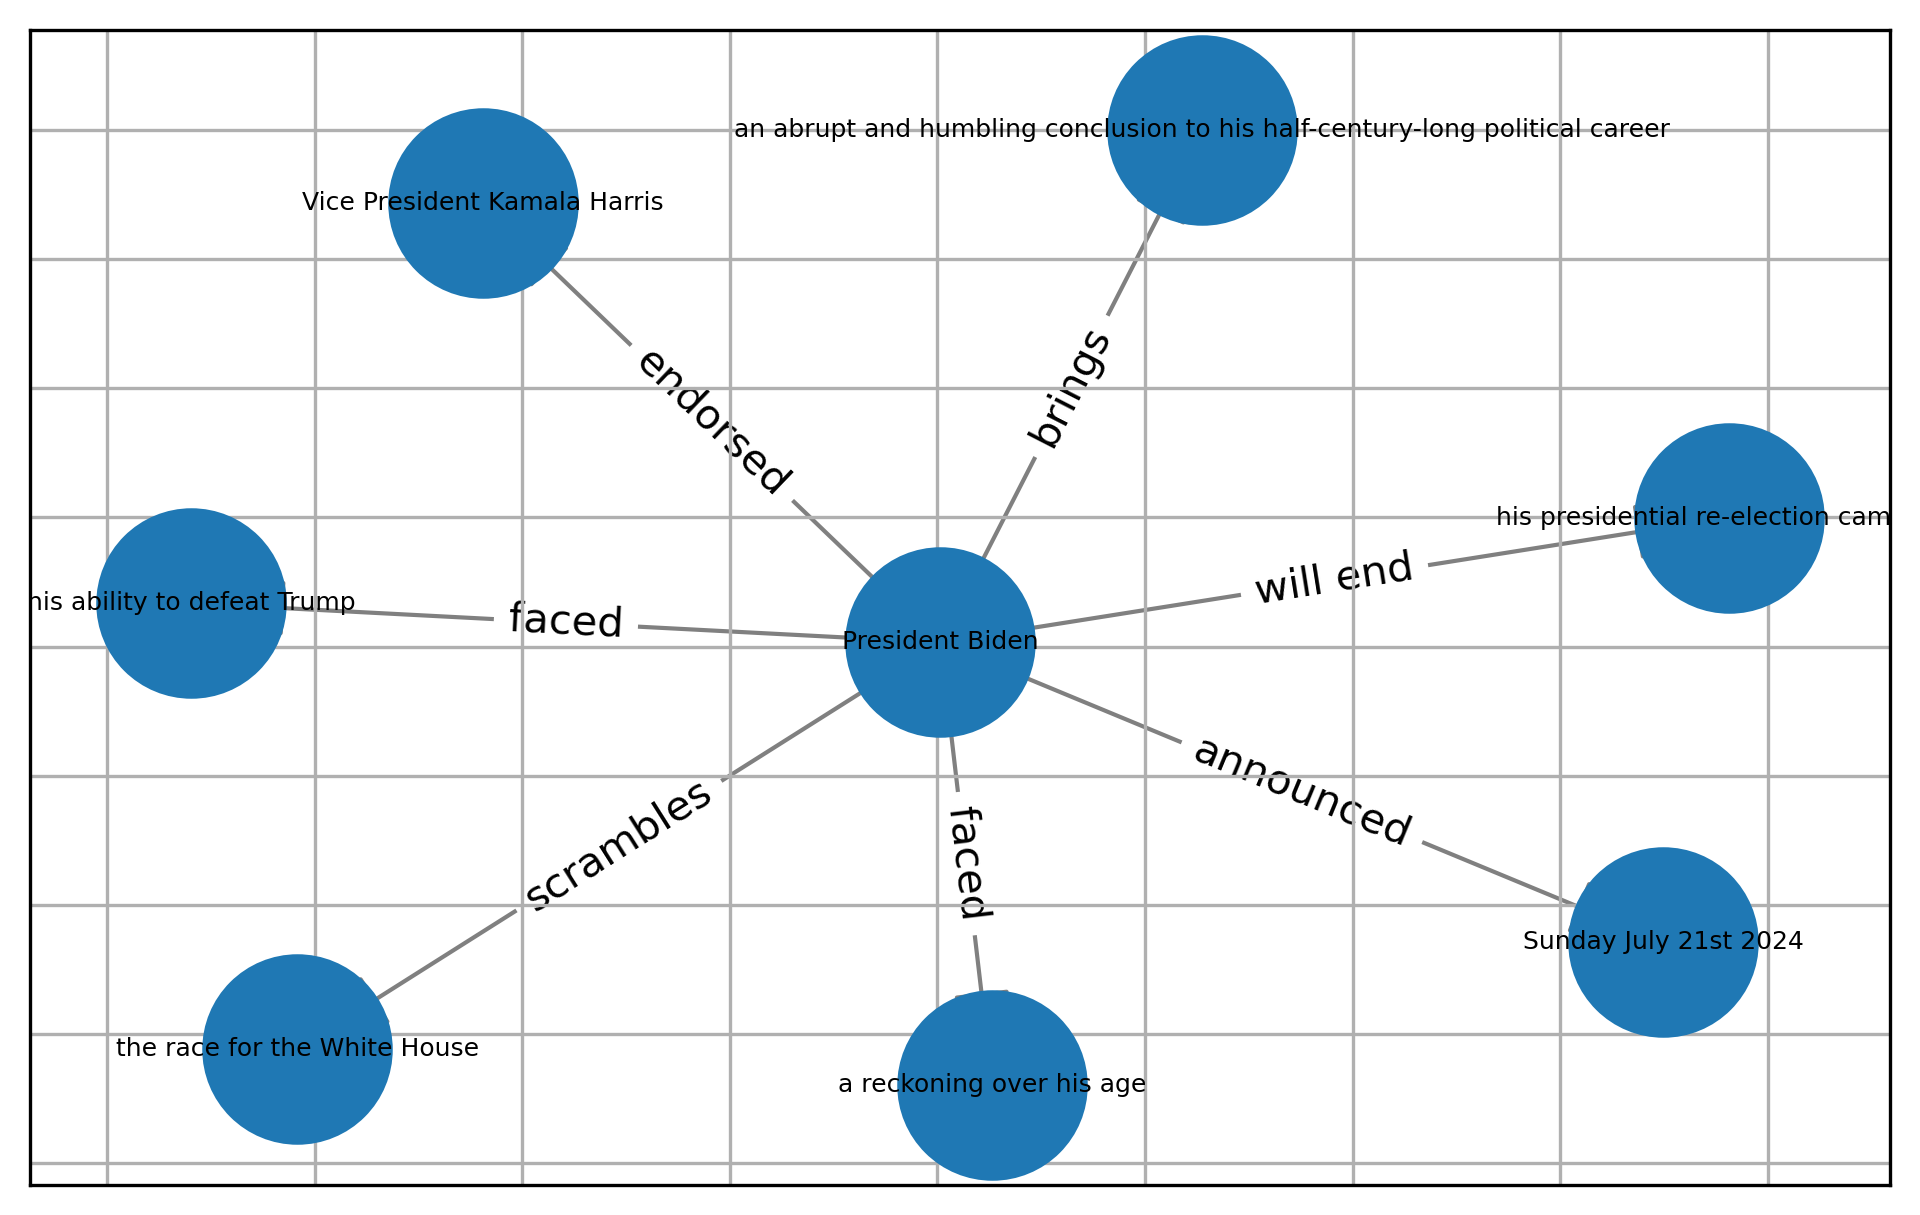

In [34]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G = nx.DiGraph()
G.add_edges_from((source, target, {'relation': relation}) for source, target, relation in graph.get_triples())

# Plot the graph
plt.figure(figsize=(8,5), dpi=300)
pos = nx.spring_layout(G, k=1, seed=0)

nx.draw_networkx_nodes(G, pos, node_size=2000)
nx.draw_networkx_edges(G, pos, edge_color='gray', arrowsize=30)
nx.draw_networkx_labels(G, pos, font_size=6)
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Display the plot
plt.show()


In [37]:
graph.get_topological_sort()

['President Biden',
 'a reckoning over his age',
 'his ability to defeat Trump',
 'Vice President Kamala Harris',
 'Sunday July 21st 2024',
 'his presidential re-election campaign',
 'an abrupt and humbling conclusion to his half-century-long political career',
 'the race for the White House']

In [38]:
chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=graph, verbose=True)
chain.run("What day did Biden make the anouncement?") 

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Entities Extracted:
 Biden
Full Context:


> Finished chain.


"\n\nI don't know."

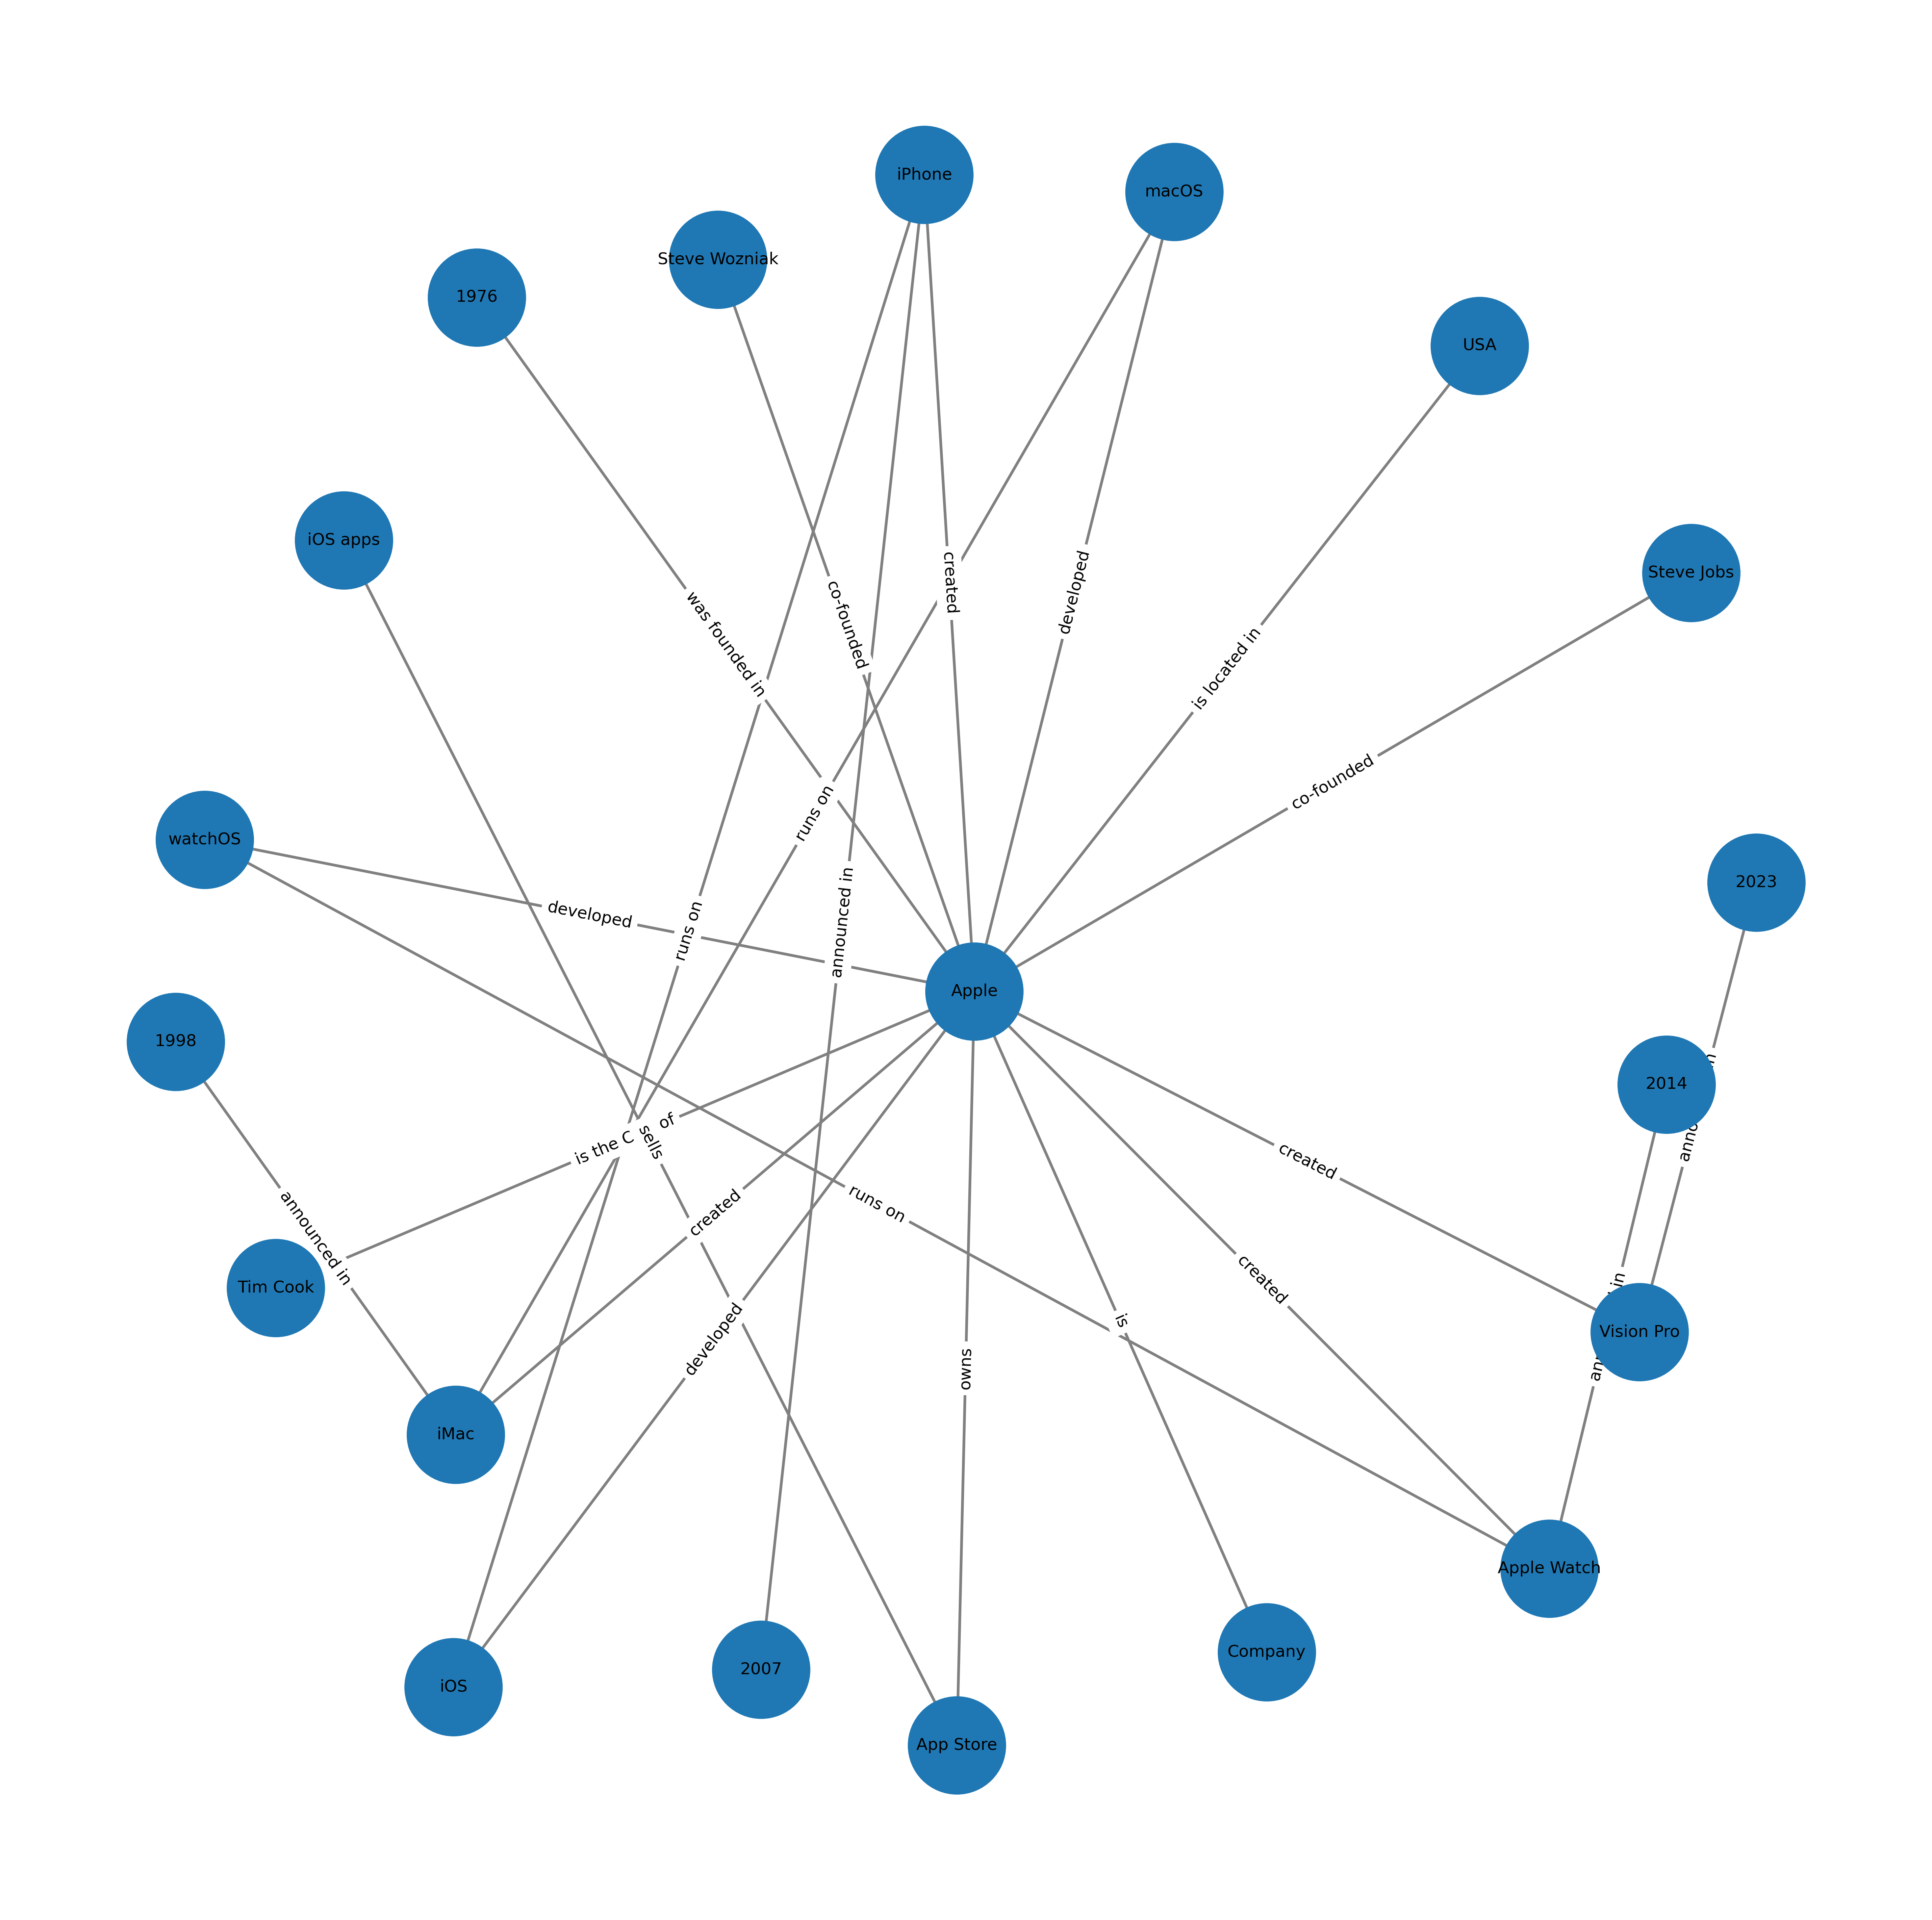

In [39]:
from langchain.graphs.networkx_graph import KnowledgeTriple

# Knowledge graph
kg = [
    ('Apple', 'is', 'Company'),
    ('Apple', 'created', 'iMac'),
    ('Apple', 'created', 'iPhone'),
    ('Apple', 'created', 'Apple Watch'),
    ('Apple', 'created', 'Vision Pro'),

    ('Apple', 'developed', 'macOS'),
    ('Apple', 'developed', 'iOS'),
    ('Apple', 'developed', 'watchOS'),

    ('Apple', 'is located in', 'USA'),
    ('Steve Jobs', 'co-founded', 'Apple'),
    ('Steve Wozniak', 'co-founded', 'Apple'),
    ('Tim Cook', 'is the CEO of', 'Apple'),

    ('iOS', 'runs on', 'iPhone'),
    ('macOS', 'runs on', 'iMac'),
    ('watchOS', 'runs on', 'Apple Watch'),

    ('Apple', 'was founded in', '1976'),
    ('Apple', 'owns', 'App Store'),
    ('App Store', 'sells', 'iOS apps'),

    ('iPhone', 'announced in', '2007'),
    ('iMac', 'announced in', '1998'),
    ('Apple Watch', 'announced in', '2014'),
    ('Vision Pro', 'announced in', '2023'),
]

graph = index_creator.from_text('')
for (node1, relation, node2) in kg:
    graph.add_triple(KnowledgeTriple(node1, relation, node2))
    
# Create directed graph
G = nx.DiGraph()
for node1, relation, node2 in kg:
    G.add_edge(node1, node2, label=relation)

# Plot the graph
plt.figure(figsize=(25, 25), dpi=300)
pos = nx.spring_layout(G, k=2, iterations=50, seed=0)

nx.draw_networkx_nodes(G, pos, node_size=5000)
nx.draw_networkx_edges(G, pos, edge_color='gray', edgelist=G.edges(), width=2)
nx.draw_networkx_labels(G, pos, font_size=12)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

# Display the plot
plt.axis('off')
plt.show()

In [ ]:
chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=graph, verbose=True)
chain.run(question)

In [53]:
from langchain.graphs import Neo4jGraph  # Import Neo4jGraph

os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "shafaksan@gmail.com"
os.environ["NEO4J_PASSWORD"] = "fjHqI6bjv4kh_R3lEl3dFpTT5_6VtK92ycopR2mKna8"

graph = Neo4jGraph()

ValueError: Could not connect to Neo4j database. Please ensure that the username and password are correct

In [57]:
from langchain.document_loaders import WikipediaLoader
from langchain.text_splitter import TokenTextSplitter

# Read the wikipedia article
raw_documents = WikipediaLoader(query="Elizabeth I").load()

# Define chunking strategy
text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=24)
documents = text_splitter.split_documents(raw_documents[:3])


/Users/ozkansafak/anaconda3/lib/python3.10/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/ozkansafak/anaconda3/lib/python3.10/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
